In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import zipfile

In [2]:
import gensim
from gensim.models import Word2Vec,KeyedVectors
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [3]:
zip_files = ['/kaggle/input/quora-question-pairs/train.csv.zip', 
             '/kaggle/input/quora-question-pairs/test.csv.zip', 
             '/kaggle/input/quora-question-pairs/sample_submission.csv.zip']

working_dir = '/kaggle/working/'

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(working_dir)

print("Unzipped files.")

Unzipped files.


In [4]:
train_df = pd.read_csv("/kaggle/working/train.csv")
test_df = pd.read_csv("/kaggle/working/test.csv")

/tmp/ipykernel_13/2114699013.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("/kaggle/working/test.csv")


In [5]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
print("Train dataframe:", train_df.shape)
print("Test dataframe:", test_df.shape)

Train dataframe: (404290, 6)
Test dataframe: (3563475, 3)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
# drop missing values
train_df = train_df.dropna()
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [9]:
# duplicate rows
train_df.duplicated().sum()

0

is_duplicate
0    255024
1    149263
Name: count, dtype: int64
is_duplicate
0    63.079941
1    36.920059
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

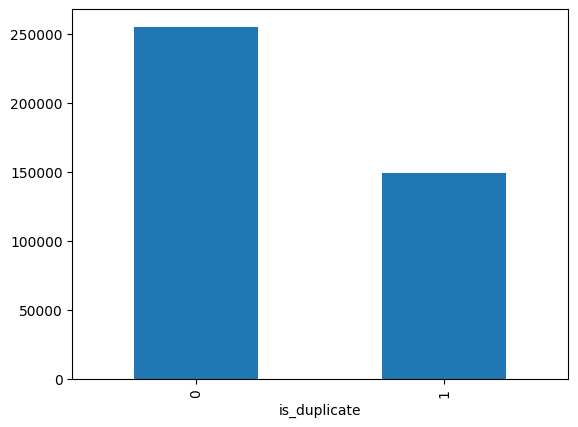

In [10]:
# Distribution of duplicate vs non-duplicate pairs

print(train_df['is_duplicate'].value_counts())
print((train_df['is_duplicate'].value_counts()/train_df['is_duplicate'].count())*100)
train_df['is_duplicate'].value_counts().plot(kind='bar')

In [11]:
# Repeated questions

qid = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537929
Number of questions getting repeated 111778


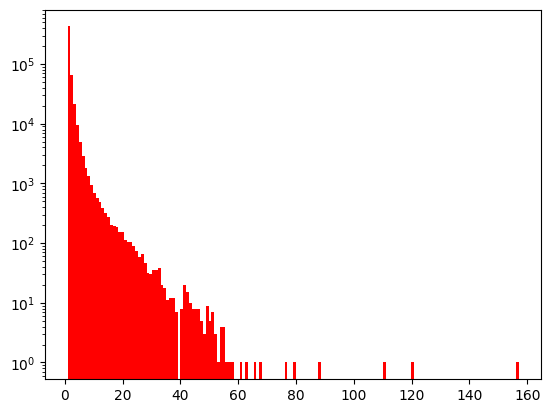

In [12]:
# Log histogram of repeated questions

plt.hist(qid.value_counts().values,bins=160, color='r')
plt.yscale('log')
plt.show()

In [13]:
# Creating corpus

corpus = train_df['question1'].tolist() + train_df['question2'].tolist()

story = []
for sent in tqdm(corpus):
    story.append(simple_preprocess(sent))

100%|██████████| 808574/808574 [00:14<00:00, 57207.39it/s]


## Data Cleaning

In [14]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stemmer = PorterStemmer()
def process_word_list(word_list):
    meaningful_words = [
        stemmer.stem(word)  # Applying stemming
        for word in word_list
        if word.lower() not in stopwords.words("english")  # Removing stopwords
    ]
    return meaningful_words

cleaned_story = [process_word_list(sublist) for sublist in tqdm(story)]

100%|██████████| 808574/808574 [15:11<00:00, 887.01it/s]


In [16]:
word2vec_model = gensim.models.Word2Vec(window = 5, min_count = 2, vector_size=30)
word2vec_model.build_vocab(cleaned_story)
word2vec_model.train(cleaned_story, 
            total_examples = word2vec_model.corpus_count, 
            epochs = word2vec_model.epochs)

(20497527, 21715385)

In [17]:
train_df["Ques1_Cleaned"] = cleaned_story[:len(train_df)]
train_df["Ques2_Cleaned"] = cleaned_story[len(train_df):]

In [18]:
sample_data = train_df.copy() 
sample_data.reset_index(inplace = True, drop = True)

## Custom Features

In [19]:
from textblob import TextBlob

def text_analysis(word_list):
    # Join the list of words into a text string
    text = " ".join(word_list)

    # Create a TextBlob object
    blob = TextBlob(text)

    # Sentiment Analysis
    polarity_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity

    # Word Metrics
    word_count = len(word_list)
    average_word_length = sum(len(word) for word in word_list) / word_count

    # Sentence Metrics
    sentence_count = len(blob.sentences)
    average_sentence_length = word_count / sentence_count

    # FOG Index
    complex_word_count = len([word for word in word_list if len(word) > 3])
    fog_index = 0.4 * (average_sentence_length + complex_word_count / word_count)
    
    return np.array([average_word_length, word_count, average_sentence_length, fog_index, complex_word_count])

In [20]:
# Converting text columns into vectors

vec1 = np.zeros((len(sample_data), 30))
vec2 = np.zeros((len(sample_data), 30))
other_features = np.zeros((len(sample_data), 10))

for i in tqdm(range(len(sample_data))):
    
    text1 = sample_data["Ques1_Cleaned"][i]
    text2 = sample_data["Ques2_Cleaned"][i]
    
    if len(text1) != 0:
        vec1[i] = (sum([word2vec_model.wv[word] for word in text1 if word in word2vec_model.wv.index_to_key]) / len(text1))
        blob1 = text_analysis(text1)
    else:
        vec1[i] = np.zeros((30,))
        blob1 = np.zeros((5,))
    if len(text2) != 0:
        vec2[i] = (sum([word2vec_model.wv[word] for word in text2 if word in word2vec_model.wv.index_to_key]) / len(text2))
        blob2 = text_analysis(text2)
    else:
        vec2i = np.zeros((30,))
        blob2 = np.zeros((5,))
    other_features[i] = np.concatenate([blob1, blob2])

100%|██████████| 404287/404287 [09:52<00:00, 682.48it/s]


In [21]:
sample_data = pd.concat([sample_data, 
                        pd.DataFrame(vec1, columns = np.arange(0, 30)),
                        pd.DataFrame(vec2, columns = np.arange(30, 60)),
                        pd.DataFrame(other_features, columns = np.arange(60, 70))], axis = 1)
sample_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,Ques1_Cleaned,Ques2_Cleaned,0,1,...,60,61,62,63,64,65,66,67,68,69
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",-1.179470,-0.564270,...,4.857143,7.0,7.0,3.200000,7.0,4.833333,6.0,6.0,2.80,6.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[stori, kohinoor, koh, noor, diamond]","[would, happen, indian, govern, stole, kohinoo...",-0.112161,-0.622921,...,5.400000,5.0,5.0,2.320000,4.0,5.400000,10.0,10.0,4.36,9.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]",0.127389,-0.911445,...,5.500000,6.0,6.0,2.666667,4.0,5.200000,5.0,5.0,2.32,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mental, lone, solv]","[find, remaind, math, math, divid]",0.725096,-1.650460,...,4.666667,3.0,3.0,1.600000,3.0,4.800000,5.0,5.0,2.40,5.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]",0.161500,-0.377102,...,4.800000,10.0,10.0,4.320000,8.0,4.800000,5.0,5.0,2.40,5.0


In [22]:
pip install scikit-learn==1.2.2

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install imbalanced-learn==0.12.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [24]:
# SMOTE Oversampling (because data is imbalanced)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
xresampled, yresampled = smote.fit_resample(sample_data.iloc[:,8:], sample_data["is_duplicate"])
xresampled.shape, yresampled.shape

((510048, 70), (510048,))

## Model Building

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(xresampled, yresampled, test_size = 0.2)
X_train.shape, y_train.shape

((408038, 70), (408038,))

### 1. Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.8584158415841584

### 2. XGBoost

In [27]:
import xgboost as xg

xg_model = xg.XGBClassifier()
xg_model.fit(X_train, y_train)
xg_model.score(X_test, y_test)

0.8060680325458288

## Plotting Confusion Matrices and generating Classification Reports

In [28]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xg = xg_model.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_xg = confusion_matrix(y_test, y_pred_xg)
class_report_rf = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict = True))
class_report_xg = pd.DataFrame(classification_report(y_test, y_pred_xg, output_dict = True))

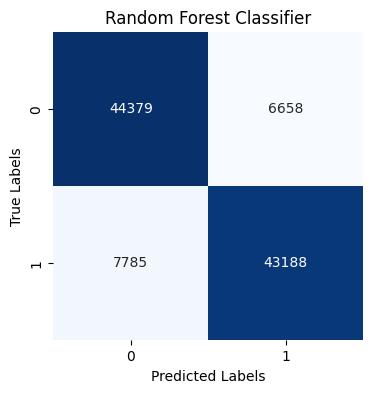

In [29]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Classifier')
plt.show()

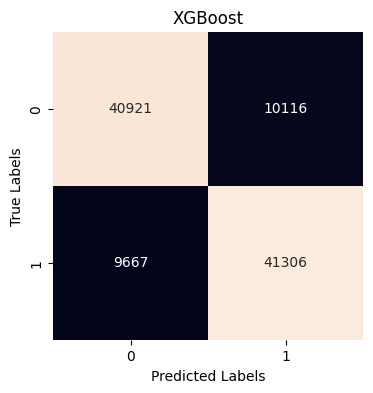

In [30]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_xg, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost')
plt.show()

In [31]:
class_report_rf

,0,1,accuracy,macro avg,weighted avg
precision,0.850759,0.866429,0.858416,0.858594,0.858589
recall,0.869546,0.847272,0.858416,0.858409,0.858416
f1-score,0.860050,0.856743,0.858416,0.858397,0.858398
support,51037.000000,50973.000000,0.858416,102010.000000,102010.000000


In [32]:
class_report_xg

,0,1,accuracy,macro avg,weighted avg
precision,0.808907,0.803275,0.806068,0.806091,0.806093
recall,0.801791,0.810351,0.806068,0.806071,0.806068
f1-score,0.805333,0.806797,0.806068,0.806065,0.806065
support,51037.000000,50973.000000,0.806068,102010.000000,102010.000000


### Inference function

In [33]:
def inference(sample1, sample2, model):
    inf_text1 = process_word_list(sample1.split())
    inf_text2 = process_word_list(sample2.split())

    inf_vec1 = np.zeros((1, 30))
    inf_vec2 = np.zeros((1, 30))
    inf_other_features = np.zeros((1, 10))

    if len(inf_text1) != 0:
        inf_vec1[0] = (sum([word2vec_model.wv[word] for word in inf_text1 if word in word2vec_model.wv.index_to_key]) / len(inf_text1))
        inf_blob1 = text_analysis(inf_text1)
    else:
        inf_vec1[0] = np.zeros((30,))
        inf_blob1 = np.zeros((5,))
    if len(inf_text2) != 0:
        inf_vec2[0] = (sum([word2vec_model.wv[word] for word in inf_text2 if word in word2vec_model.wv.index_to_key]) / len(inf_text2))
        inf_blob2 = text_analysis(inf_text2)
    else:
        inf_vec2[0] = np.zeros((30,))
        inf_blob2 = np.zeros((5,))
    inf_other_features[0] = np.concatenate([inf_blob1, inf_blob2])

    inf_data = pd.DataFrame({})
    inf_data = pd.concat([inf_data, 
                            pd.DataFrame(inf_vec1, columns = np.arange(0, 30)),
                            pd.DataFrame(inf_vec2, columns = np.arange(30, 60)),
                            pd.DataFrame(inf_other_features, columns = np.arange(60, 70))], axis = 1)
    output = model.predict(inf_data)
    if out == 0:
        print("Not Duplicate")
    else:
        print("Duplicate")


## Deep Learning Approaches

In [34]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
xresampled_dl, yresampled_dl = ros.fit_resample(train_df.iloc[:,3:5], train_df["is_duplicate"])
xresampled_dl.shape, yresampled_dl.shape

((510048, 2), (510048,))

In [35]:
que1 = np.array(xresampled_dl['question1'].tolist())
que2 = np.array(xresampled_dl['question2'].tolist())

docx = []
for i in tqdm(range(len(que1))):
    docx.append(que1[i] + " " + que2[i])

100%|██████████| 510048/510048 [00:03<00:00, 147535.27it/s]


In [36]:
lengths = []
for sent in tqdm(docx):
    lengths.append(len(sent.split()))

100%|██████████| 510048/510048 [00:00<00:00, 596632.20it/s]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

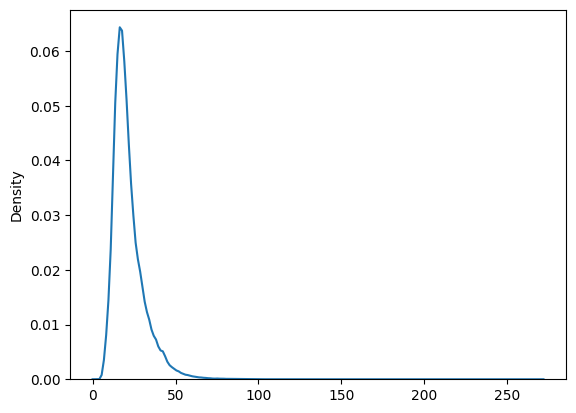

In [37]:
sns.kdeplot(lengths)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 35)

2025-07-03 09:39:30.916929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751535571.189677      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751535571.281458      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1. RNN

In [39]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(sequences.max()+1, output_dim = 30, input_length = 35))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-07-03 09:40:11.182856: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])
history = model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7139 - loss: 0.5594 - val_accuracy: 0.4028 - val_loss: 0.8755
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.7872 - loss: 0.4533 - val_accuracy: 0.6975 - val_loss: 0.5906
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8251 - loss: 0.3839 - val_accuracy: 0.7887 - val_loss: 0.4620
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8587 - loss: 0.3206 - val_accuracy: 0.8403 - val_loss: 0.3687
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.8814 - loss: 0.2762 - val_accuracy: 0.8698 - val_loss: 0.3232
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.8982 - loss: 0.2401 - val_accuracy: 0.9461 - val_loss: 0.1756
Epoch 7/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9116 - loss: 0.2125 - val_accuracy: 0.8677 - val_loss: 0.3253
Epoch 8/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9220 - loss: 0.1898 - 

### 2. LSTM

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

max_seq_length = 35
vocab_size = sequences.max() + 1

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_length))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
history2 = lstm_model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 172s 404ms/step - accuracy: 0.7107 - loss: 0.5601 - val_accuracy: 0.6234 - val_loss: 0.6649
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 208s 419ms/step - accuracy: 0.7826 - loss: 0.4569 - val_accuracy: 0.6619 - val_loss: 0.6140
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 203s 422ms/step - accuracy: 0.8103 - loss: 0.4018 - val_accuracy: 0.8061 - val_loss: 0.4376
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 161s 393ms/step - accuracy: 0.8370 - loss: 0.3503 - val_accuracy: 0.8062 - val_loss: 0.4387
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 156s 382ms/step - accuracy: 0.8598 - loss: 0.3051 - val_accuracy: 0.8524 - val_loss: 0.3612
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 167s 408ms/step - accuracy: 0.8780 - loss: 0.2673 - val_accuracy: 0.8043 - val_loss: 0.4185
Epoch 7/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 155s 378ms/step - accuracy: 0.8924 - loss: 0.2392 - val_accuracy: 0.8968 - val_loss: 0.2862
Epoch 8/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 161s 395ms/step - accuracy: 0.9059 -